In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests_hw4 import test_prediction, test_generation

/home/psl/.conda/envs/hw3p2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)
devset = np.load('../dataset/wiki.valid.npy', allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# data loader

class LanguageModelDataLoader(DataLoader):
    
    def __init__(self, dataset, batch_size, seq_len=25, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.shuffle = shuffle

    def __iter__(self):
        # concatenate your articles and build into batches
        if self.shuffle:
            np.random.shuffle(self.dataset)
        data = np.concatenate(self.dataset)

        self.inputs = list()
        self.targets = list()
        for i in range((len(data) - 1) // self.seq_len):
            if i % self.batch_size == 0 and i != 0:
                yield torch.from_numpy(np.array(self.inputs)), torch.from_numpy(np.array(self.targets))
                self.inputs = list()
                self.targets = list()
            self.inputs.append(np.array(data[i * self.seq_len : (i + 1) * self.seq_len]))
            self.targets.append(np.array(data[i * self.seq_len + 1 : (i + 1) * self.seq_len + 1]))
    
    def __len__(self):
        return (len(np.concatenate(self.dataset)) - 1) // self.seq_len
        

In [4]:
# Original implementation:
# https://github.com/salesforce/awd-lstm-lm/blob/master/locked_dropout.py

import torch.nn as nn


class LockedDropout(nn.Module):
    """ LockedDropout applies the same dropout mask to every time step.

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. Here is
    their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        p (float): Probability of an element in the dropout mask to be zeroed.
    """

    def __init__(self, p=0.2):
        self.p = p
        super().__init__()

    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [sequence length, batch size, rnn hidden size]): Input to
                apply dropout too.
        """
        if not self.training or not self.p:
            return x
            
        x = x.clone()
        mask = x.new_empty(1, x.size(1), x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) + ')'

In [5]:
# model

class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size, embedding_dim=512, hidden_dim=1024, layers=2, tie_weight=False, lock=False):
        super(LanguageModel, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.layers = layers
        self.tie_weight = tie_weight
        self.lock = lock

        self.embedding = nn.Embedding(vocab_size, self.embedding_dim)

        if lock:
            if self.tie_weight:
                self.lstms = [nn.LSTM(self.embedding_dim, self.embedding_dim, 1, batch_first=True).to(device)]
            else:
                self.lstms = [nn.LSTM(self.embedding_dim, self.hidden_dim, 1, batch_first=True).to(device)]

            for layer in range(self.layers - 1):
                if self.tie_weight:
                    self.lstms.append(nn.LSTM(self.embedding_dim, self.embedding_dim, 1, batch_first=True).to(device))
                else:
                    self.lstms.append(nn.LSTM(self.hidden_dim, self.hidden_dim, 1, batch_first=True).to(device))
        else:
            if self.tie_weight:
                self.lstms = nn.LSTM(self.embedding_dim, self.embedding_dim, self.layers, dropout=0.3, batch_first=True)
            else:
                self.lstms = nn.LSTM(self.embedding_dim, self.hidden_dim, self.layers, dropout=0.3, batch_first=True)
            
        self.locked_dropout = LockedDropout(p=0.2)

        if self.tie_weight:
            self.classification = nn.Linear(self.embedding_dim, vocab_size)
        else:
            self.classification = nn.Linear(self.hidden_dim, vocab_size)

    def forward(self, x, h0=None):
        emb = self.embedding(x)

        h = h0
        if self.lock:
            for lstm in self.lstms:
                if h0:
                    emb, h = lstm(emb, h)
                else:
                    emb, h = lstm(emb)
                emb = self.locked_dropout(emb)
        else:
            if h0:
                emb, h = self.lstms(emb, h)
            else:
                emb, h = self.lstms(emb)
            emb = self.locked_dropout(emb)

        outputs = self.classification(emb)

        return outputs, h


    


In [6]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 50
BATCH_SIZE = 256


In [7]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id

        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.criterion = nn.CrossEntropyLoss()
        self.scaler = torch.cuda.amp.GradScaler()

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        
        for batch_idx, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_idx + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
        inputs = inputs.type(torch.LongTensor).to(device)
        targets = targets.type(torch.LongTensor).to(device)

        outputs, _ = self.model(inputs)
        
        loss = self.criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))
        
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()

        return loss.detach().cpu().numpy()

    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [8]:
class TestLanguageModel:
    def prediction(inputs, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        inputs = torch.from_numpy(inputs).type(torch.LongTensor).to(device)
        outputs, _ = model(inputs)

        return outputs[:, -1, :].detach().cpu().numpy()
        
    def generation(inputs, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """ 
        model.eval()
        with torch.no_grad():
            result = []
            inputs = torch.from_numpy(inputs).type(torch.LongTensor).to(device)
            outputs, hidden = model(inputs)

            pred_word = torch.argmax(outputs[:, -1, :], dim=1).unsqueeze(dim=1).to(device)
            result.append(pred_word)

            seq = inputs
            for i in range(forward - 1):
                seq = torch.cat((seq, pred_word), dim=1)
                outputs, hidden = model(seq, hidden)
                pred_word = torch.argmax(outputs[:, -1, :], dim=1).unsqueeze(dim=1)
                result.append(pred_word)

        return torch.cat(result, dim=1).cpu().detach().numpy()
        

In [9]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1651304189


In [10]:
model = LanguageModel(len(vocab)).to(device)
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

In [11]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()
    

[TRAIN]  Epoch [1/50]   Loss: 7.5354
[VAL]  Epoch [1/50]   Loss: 6.6515
Saving model, predictions and generated output for epoch 0 with NLL: 6.6515455
[TRAIN]  Epoch [2/50]   Loss: 7.1705
[VAL]  Epoch [2/50]   Loss: 6.6631
[TRAIN]  Epoch [3/50]   Loss: 7.1376
[VAL]  Epoch [3/50]   Loss: 6.5865
Saving model, predictions and generated output for epoch 2 with NLL: 6.586498
[TRAIN]  Epoch [4/50]   Loss: 6.9512
[VAL]  Epoch [4/50]   Loss: 6.2308
Saving model, predictions and generated output for epoch 3 with NLL: 6.230752
[TRAIN]  Epoch [5/50]   Loss: 6.7512
[VAL]  Epoch [5/50]   Loss: 6.1299
Saving model, predictions and generated output for epoch 4 with NLL: 6.129898
[TRAIN]  Epoch [6/50]   Loss: 6.6100
[VAL]  Epoch [6/50]   Loss: 6.0006
Saving model, predictions and generated output for epoch 5 with NLL: 6.0005608
[TRAIN]  Epoch [7/50]   Loss: 6.5012
[VAL]  Epoch [7/50]   Loss: 5.9035
Saving model, predictions and generated output for epoch 6 with NLL: 5.903493
[TRAIN]  Epoch [8/50]   Lo

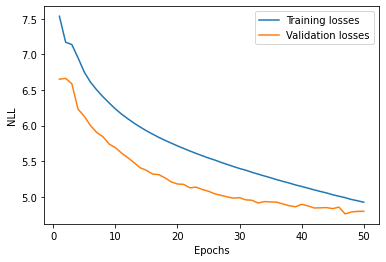

In [12]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [13]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | the first of the first season in the United States
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = <eol> The first season was the first
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | season , and the first time that the album was
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | and the <unk> <unk> <unk> <unk> , and the <unk>
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | @-@ time , and the first time that the player
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | <unk> <unk> , and <unk> <unk> , who was a
Input | Output #6: <u